[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/flax/blob/main/docs/getting_started.ipynb)
[![Open On GitHub](https://img.shields.io/badge/Open-on%20GitHub-blue?logo=GitHub)](https://github.com/google/flax/blob/main/docs/getting_started.ipynb)

# Quickstart

Welcome to Flax!

Flax is an open source Python neural network library built on top of [JAX](https://github.com/google/jax). This tutorial demonstrates how to construct a simple convolutional neural
network (CNN) using the [Flax](https://flax.readthedocs.io) Linen API and train
the network for image classification on the MNIST dataset.

## 1. Install Flax

In [1]:
!pip install -q flax

## 2. Loading data

Flax can use any
data-loading pipeline and this example demonstrates how to utilize TFDS. Define a function that loads and prepares the MNIST dataset and converts the
samples to floating-point numbers.

In [2]:
import tensorflow_datasets as tfds  # TFDS for MNIST
import tensorflow as tf             # TensorFlow operations

def get_datasets(num_epochs, batch_size):
  """Load MNIST train and test datasets into memory."""
  train_ds = tfds.load('mnist', split='train')
  test_ds = tfds.load('mnist', split='test')

  train_ds = train_ds.map(lambda sample: {'image': tf.cast(sample['image'],
                                                           tf.float32) / 255.,
                                          'label': sample['label']}) # normalize train set
  test_ds = test_ds.map(lambda sample: {'image': tf.cast(sample['image'],
                                                         tf.float32) / 255.,
                                        'label': sample['label']}) # normalize test set

  train_ds = train_ds.repeat(num_epochs).shuffle(1024) # create shuffled dataset by allocating a buffer size of 1024 to randomly draw elements from
  train_ds = train_ds.batch(batch_size, drop_remainder=True).prefetch(1) # group into batches of batch_size and skip incomplete batch, prefetch the next sample to improve latency
  test_ds = test_ds.shuffle(1024) # create shuffled dataset by allocating a buffer size of 1024 to randomly draw elements from
  test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1) # group into batches of batch_size and skip incomplete batch, prefetch the next sample to improve latency

  return train_ds, test_ds

## 3. Define network

Create a convolutional neural network with the Linen API by subclassing
[Flax Module](https://flax.readthedocs.io/en/latest/api_reference/flax.linen/module.html).
Because the architecture in this example is relatively simple—you're just
stacking layers—you can define the inlined submodules directly within the
`__call__` method and wrap it with the
[`@compact`](https://flax.readthedocs.io/en/latest/api_reference/flax.linen/decorators.html#flax.linen.compact)
decorator. To learn more about the Flax Linen `@compact` decorator, refer to the [`setup` vs `compact`](https://flax.readthedocs.io/en/latest/guides/setup_or_nncompact.html) guide.

In [3]:
from flax import linen as nn  # Linen API

class CNN(nn.Module):
  """A simple CNN model."""

  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  # flatten
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=10)(x)
    return x

### View model layers

Create an instance of the Flax Module and use the [`Module.tabulate`](https://flax.readthedocs.io/en/latest/api_reference/flax.linen/module.html#flax.linen.Module.tabulate) method to visualize a table of the model layers by passing an RNG key and template image input.

In [9]:
import jax
import jax.numpy as jnp  # JAX NumPy

cnn = CNN()
print(cnn.tabulate(jax.random.key(0), jnp.ones((1, 28, 28, 1)),
                  #  compute_flops=True,
                  #  compute_vjp_flops=True
                   ))


                                         CNN Summary                                         
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs              ┃ outputs             ┃ params                     ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ CNN    │ float32[1,28,28,1]  │ float32[1,10]       │                            │
├─────────┼────────┼─────────────────────┼─────────────────────┼────────────────────────────┤
│ Conv_0  │ Conv   │ float32[1,28,28,1]  │ float32[1,28,28,32] │ bias: float32[32]          │
│         │        │                     │                     │ kernel: float32[3,3,1,32]  │
│         │        │                     │                     │                            │
│         │        │                     │                     │ 320 (1.3 KB)               │
├─────────┼────────┼─────────────────────┼─────────────────

## 4. Create a `TrainState`

A common pattern in Flax is to create a single dataclass that represents the
entire training state, including step number, parameters, and optimizer state.

Because this is such a common pattern, Flax provides the class
[`flax.training.train_state.TrainState`](https://flax.readthedocs.io/en/latest/flax.training.html#train-state)
that serves most basic usecases.

In [10]:
!pip install -q clu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 68.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [11]:
from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers

We will be using the `clu` library for computing metrics. For more information on `clu`, refer to the [repo](https://github.com/google/CommonLoopUtils) and [notebook](https://colab.research.google.com/github/google/CommonLoopUtils/blob/master/clu_synopsis.ipynb#scrollTo=ueom-uBWLbeQ).

In [13]:
@struct.dataclass
class Metrics(metrics.Collection):
  accuracy: metrics.Accuracy
  loss: metrics.Average.from_output('loss')

You can then subclass `train_state.TrainState` so that it also contains metrics. This has the advantage that we only need
to pass around a single argument to functions like `train_step()` (see below) to calculate the loss, update the parameters and compute the metrics all at once.

In [14]:
class TrainState(train_state.TrainState):
  metrics: Metrics

def create_train_state(module, rng, learning_rate, momentum):
  """Creates an initial `TrainState`."""
  params = module.init(rng, jnp.ones([1, 28, 28, 1]))['params'] # initialize parameters by passing a template image
  tx = optax.sgd(learning_rate, momentum)
  return TrainState.create(
      apply_fn=module.apply, params=params, tx=tx,
      metrics=Metrics.empty())

## 5. Training step

A function that:

- Evaluates the neural network given the parameters and a batch of input images
  with [`TrainState.apply_fn`](https://flax.readthedocs.io/en/latest/api_reference/flax.training.html#flax.training.train_state.TrainState) (which contains the [`Module.apply`](https://flax.readthedocs.io/en/latest/api_reference/flax.linen/module.html#flax.linen.Module.apply)
  method (forward pass)).
- Computes the cross entropy loss, using the predefined [`optax.softmax_cross_entropy_with_integer_labels()`](https://optax.readthedocs.io/en/latest/api.html#optax.softmax_cross_entropy_with_integer_labels). Note that this function expects integer labels, so there is no need to convert labels to onehot encoding.
- Evaluates the gradient of the loss function using
  [`jax.grad`](https://jax.readthedocs.io/en/latest/jax.html#jax.grad).
- Applies a
  [pytree](https://jax.readthedocs.io/en/latest/pytrees.html#pytrees-and-jax-functions)
  of gradients to the optimizer to update the model's parameters.

Use JAX's [@jit](https://jax.readthedocs.io/en/latest/jax.html#jax.jit)
decorator to trace the entire `train_step` function and just-in-time compile
it with [XLA](https://www.tensorflow.org/xla) into fused device operations
that run faster and more efficiently on hardware accelerators.

In [15]:
@jax.jit
def train_step(state, batch):
  """Train for a single step."""
  def loss_fn(params):
    logits = state.apply_fn({'params': params}, batch['image'])
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
    return loss
  grad_fn = jax.grad(loss_fn)
  grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state

## 6. Metric computation

Create a separate function for loss and accuracy metrics. Loss is calculated using the `optax.softmax_cross_entropy_with_integer_labels` function, while accuracy is calculated using `clu.metrics`.

In [16]:
@jax.jit
def compute_metrics(*, state, batch):
  logits = state.apply_fn({'params': state.params}, batch['image'])
  loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
  metric_updates = state.metrics.single_from_model_output(
    logits=logits, labels=batch['label'], loss=loss)
  metrics = state.metrics.merge(metric_updates)
  state = state.replace(metrics=metrics)
  return state

## 7. Download data

In [17]:
num_epochs = 10
batch_size = 32

train_ds, test_ds = get_datasets(num_epochs, batch_size)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


## 8. Seed randomness

- Set the TF random seed to ensure dataset shuffling (with `tf.data.Dataset.shuffle`) is reproducible.
- Get one
  [PRNGKey](https://jax.readthedocs.io/en/latest/_autosummary/jax.random.PRNGKey.html#jax.random.PRNGKey)
  and use it for parameter initialization. (Learn
  more about
  [JAX PRNG design](https://jax.readthedocs.io/en/latest/jax-101/05-random-numbers.html)
  and [PRNG chains](https://flax.readthedocs.io/en/latest/philosophy.html#how-are-parameters-represented-and-how-do-we-handle-general-differentiable-algorithms-that-update-stateful-variables).)

In [18]:
tf.random.set_seed(0)

In [19]:
init_rng = jax.random.key(0)

## 9. Initialize the `TrainState`

Remember that the function `create_train_state` initializes the model parameters, optimizer and metrics
and puts them into the training state dataclass that is returned.

In [20]:
learning_rate = 0.01
momentum = 0.9

In [21]:
state = create_train_state(cnn, init_rng, learning_rate, momentum)
del init_rng  # Must not be used anymore.

## 10. Train and evaluate

Create a "shuffled" dataset by:
- Repeating the dataset equal to the number of training epochs
- Allocating a buffer of size 1024 (containing the first 1024 samples in the dataset) of which to randomly sample batches from
  - Everytime a sample is randomly drawn from the buffer, the next sample in the dataset is loaded into the buffer

Define a training loop that:
- Randomly samples batches from the dataset.
- Runs an optimization step for each training batch.
- Computes the mean training metrics across each batch in an epoch.
- Computes the metrics for the test set using the updated parameters.
- Records the train and test metrics for visualization.

Once the training and testing is done after 10 epochs, the output should show that your model was able to achieve approximately 99% accuracy.

In [22]:
# since train_ds is replicated num_epochs times in get_datasets(), we divide by num_epochs
num_steps_per_epoch = train_ds.cardinality().numpy() // num_epochs

In [23]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

In [24]:
for step,batch in enumerate(train_ds.as_numpy_iterator()):

  # Run optimization steps over training batches and compute batch metrics
  state = train_step(state, batch) # get updated train state (which contains the updated parameters)
  state = compute_metrics(state=state, batch=batch) # aggregate batch metrics

  if (step+1) % num_steps_per_epoch == 0: # one training epoch has passed
    for metric,value in state.metrics.compute().items(): # compute metrics
      metrics_history[f'train_{metric}'].append(value) # record metrics
    state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

    # Compute metrics on the test set after each training epoch
    test_state = state
    for test_batch in test_ds.as_numpy_iterator():
      test_state = compute_metrics(state=test_state, batch=test_batch)

    for metric,value in test_state.metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)

    print(f"train epoch: {(step+1) // num_steps_per_epoch}, "
          f"loss: {metrics_history['train_loss'][-1]}, "
          f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
    print(f"test epoch: {(step+1) // num_steps_per_epoch}, "
          f"loss: {metrics_history['test_loss'][-1]}, "
          f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")

train epoch: 1, loss: 0.20108075439929962, accuracy: 93.89167022705078
test epoch: 1, loss: 0.07060154527425766, accuracy: 97.73637390136719
train epoch: 2, loss: 0.05856462940573692, accuracy: 98.29000091552734
test epoch: 2, loss: 0.05444982647895813, accuracy: 98.28726196289062
train epoch: 3, loss: 0.038750313222408295, accuracy: 98.91500091552734
test epoch: 3, loss: 0.04229046404361725, accuracy: 98.5977554321289
train epoch: 4, loss: 0.029038619250059128, accuracy: 99.1550064086914
test epoch: 4, loss: 0.0398898646235466, accuracy: 98.828125
train epoch: 5, loss: 0.02216338738799095, accuracy: 99.37833404541016
test epoch: 5, loss: 0.030849218368530273, accuracy: 98.94831848144531
train epoch: 6, loss: 0.01768437586724758, accuracy: 99.51333618164062
test epoch: 6, loss: 0.034291669726371765, accuracy: 98.89823913574219
train epoch: 7, loss: 0.013878622092306614, accuracy: 99.60832977294922
test epoch: 7, loss: 0.03216234967112541, accuracy: 98.90824890136719
train epoch: 8, los

## 11. Visualize metrics

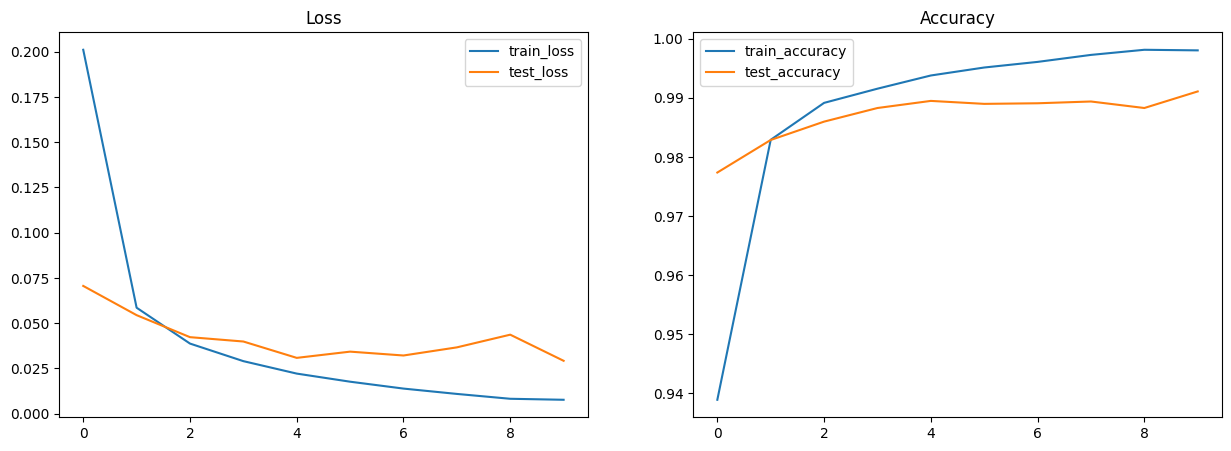

<Figure size 640x480 with 0 Axes>

In [25]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

## 12. Perform inference on test set

Define a jitted inference function `pred_step`. Use the learned parameters to do model inference on the test set and visualize the images and their corresponding predicted labels.

In [26]:
@jax.jit
def pred_step(state, batch):
  logits = state.apply_fn({'params': state.params}, test_batch['image'])
  return logits.argmax(axis=1)

test_batch = test_ds.as_numpy_iterator().next()
pred = pred_step(state, test_batch)

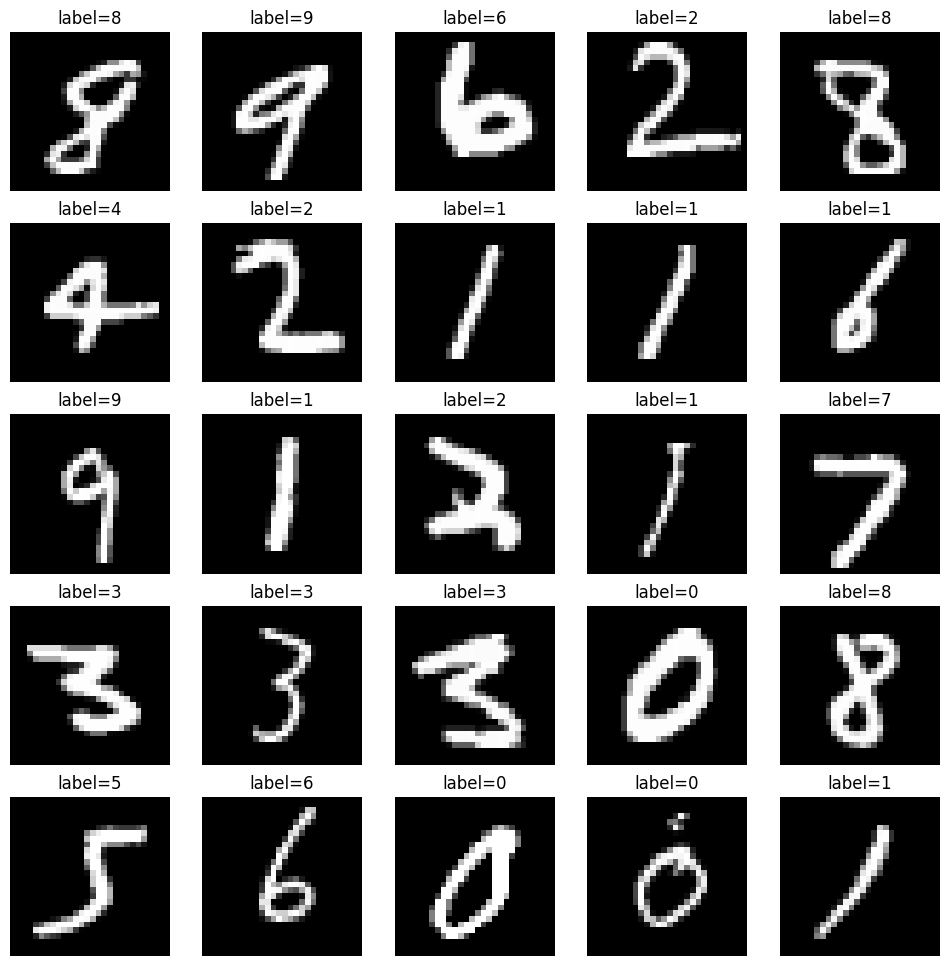

In [27]:
fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(test_batch['image'][i, ..., 0], cmap='gray')
    ax.set_title(f"label={pred[i]}")
    ax.axis('off')

Congratulations! You made it to the end of the annotated MNIST example. You can revisit
the same example, but structured differently as a couple of Python modules, test
modules, config files, another Colab, and documentation in Flax's Git repo:

[https://github.com/google/flax/tree/main/examples/mnist](https://github.com/google/flax/tree/main/examples/mnist)